In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets import load_from_disk, load_dataset, concatenate_datasets, DatasetDict
import torchmetrics
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os # Added for path joining
from IPython.lib.display import Audio as AudioDisplay



/home/pierre/Documents/Projects/PST4/AI/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------
# 2. Configuration & Setup
# -----------------------------
SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 24
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 4e-4
MODEL_SAVE_PATH = "./models_resnet.pt"
EPOCHS=20
sampling_rate = 16000
# --- Set Seeds for Reproducibility ---
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

print(f"Using device: {DEVICE}")
print(f"Number of workers: {NUM_WORKERS}")

Using device: cuda
Number of workers: 24


In [3]:
dataset = load_from_disk("../../dataset/ds_1_melspecto_noaug_balanced_chunked.hf")
dataset = dataset.with_format("torch", columns=["audio", "label"])

print("\nDataset splits:")
print({k: v.shape for k, v in dataset.items()})

print("\nDataset features:")
print(dataset["train"].features)


Dataset splits:
{'train': (352132, 2), 'val': (42198, 2), 'test': (44844, 2)}

Dataset features:
{'audio': List(List(List(Value('float64')))), 'label': ClassLabel(names=['other', 'drone'])}


In [4]:
def collate_fn_librosa(batch):
    inputs = []
    labels = []

    for item in batch:
        waveform = item["audio"]      # (8000,)
        label = item["label"]

        waveform = waveform.repeat(3, 1,1)

        inputs.append(waveform)
        labels.append(label)

    # Pad time dimension so all samples in batch have same T
    # (ResNet requires fixed size)
    inputs = torch.nn.utils.rnn.pad_sequence(
        inputs, batch_first=True
    )  # → [B, 3, 128, T_max]

    labels = torch.tensor(labels, dtype=torch.float32)

    return inputs, labels

train_loader = DataLoader(
    dataset["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_librosa,
)

val_loader = DataLoader(
    dataset["val"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_librosa,
)

test_loader = DataLoader(
    dataset["test"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_librosa,
)

batch = next(iter(train_loader))
batch

(tensor([[[[ 1.4700,  1.5219,  1.2052,  ...,  1.5650,  1.1416,  0.9592],
           [ 0.7315,  0.9493,  1.0192,  ...,  1.7539,  1.1424,  0.9015],
           [ 0.7025,  0.9481,  1.2056,  ...,  1.3771,  1.1073,  0.7451],
           ...,
           [-1.1764, -0.7634, -0.8291,  ..., -1.2427, -1.0561, -1.2142],
           [-1.4888, -1.2547, -1.0688,  ..., -1.1143, -1.0442, -1.0809],
           [-1.6458, -1.1579, -1.0631,  ..., -1.3018, -1.2201, -1.2866]],
 
          [[ 1.4700,  1.5219,  1.2052,  ...,  1.5650,  1.1416,  0.9592],
           [ 0.7315,  0.9493,  1.0192,  ...,  1.7539,  1.1424,  0.9015],
           [ 0.7025,  0.9481,  1.2056,  ...,  1.3771,  1.1073,  0.7451],
           ...,
           [-1.1764, -0.7634, -0.8291,  ..., -1.2427, -1.0561, -1.2142],
           [-1.4888, -1.2547, -1.0688,  ..., -1.1143, -1.0442, -1.0809],
           [-1.6458, -1.1579, -1.0631,  ..., -1.3018, -1.2201, -1.2866]],
 
          [[ 1.4700,  1.5219,  1.2052,  ...,  1.5650,  1.1416,  0.9592],
           [ 

In [5]:
from torchvision import models

model = models.resnet50(weights=None)

# Replace final FC for binary classification
model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


In [6]:
from tqdm import tqdm
import torch

best_val_acc = 0.0
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        x = x.to(DEVICE)
        y = y.float().to(DEVICE)

        optimizer.zero_grad()
        logits = model(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(logits) > 0.5
        correct_train += (preds == y.byte()).sum().item()
        total_train += y.size(0)

    train_acc = correct_train / total_train

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            x = x.to(DEVICE)
            y = y.float().to(DEVICE)

            logits = model(x).squeeze(1)
            loss = criterion(logits, y)
            val_loss += loss.item()

            preds = torch.sigmoid(logits) > 0.5
            correct_val += (preds == y.byte()).sum().item()
            total_val += y.size(0)

    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"--> New best model saved with Val Acc: {best_val_acc:.4f}")


Epoch 1/20 [Val]: 100%|██████████| 1319/1319 [00:09<00:00, 143.31it/s]


Epoch 1/20 | Train Loss: 0.0941 | Train Acc: 0.9660 | Val Loss: 0.0578 | Val Acc: 0.9792
--> New best model saved with Val Acc: 0.9792


Epoch 2/20 [Val]: 100%|██████████| 1319/1319 [00:09<00:00, 143.73it/s]


Epoch 2/20 | Train Loss: 0.0561 | Train Acc: 0.9814 | Val Loss: 0.0380 | Val Acc: 0.9882
--> New best model saved with Val Acc: 0.9882


Epoch 3/20 [Val]: 100%|██████████| 1319/1319 [00:09<00:00, 142.33it/s]


Epoch 3/20 | Train Loss: 0.0440 | Train Acc: 0.9857 | Val Loss: 0.0431 | Val Acc: 0.9859


Epoch 4/20 [Val]: 100%|██████████| 1319/1319 [00:12<00:00, 103.97it/s]


Epoch 4/20 | Train Loss: 0.0377 | Train Acc: 0.9880 | Val Loss: 0.0352 | Val Acc: 0.9886
--> New best model saved with Val Acc: 0.9886


Epoch 5/20 [Val]: 100%|██████████| 1319/1319 [00:17<00:00, 74.67it/s]


Epoch 5/20 | Train Loss: 0.0337 | Train Acc: 0.9892 | Val Loss: 0.0331 | Val Acc: 0.9904
--> New best model saved with Val Acc: 0.9904


Epoch 6/20 [Val]: 100%|██████████| 1319/1319 [00:13<00:00, 98.00it/s]


Epoch 6/20 | Train Loss: 0.0303 | Train Acc: 0.9904 | Val Loss: 0.0345 | Val Acc: 0.9889


Epoch 7/20 [Val]: 100%|██████████| 1319/1319 [00:17<00:00, 76.79it/s]


Epoch 7/20 | Train Loss: 0.0285 | Train Acc: 0.9909 | Val Loss: 0.0268 | Val Acc: 0.9914
--> New best model saved with Val Acc: 0.9914


Epoch 8/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 81.68it/s]


Epoch 8/20 | Train Loss: 0.0269 | Train Acc: 0.9914 | Val Loss: 0.0292 | Val Acc: 0.9906


Epoch 9/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 82.41it/s]


Epoch 9/20 | Train Loss: 0.0254 | Train Acc: 0.9921 | Val Loss: 0.0315 | Val Acc: 0.9903


Epoch 10/20 [Val]: 100%|██████████| 1319/1319 [00:15<00:00, 82.86it/s]


Epoch 10/20 | Train Loss: 0.0246 | Train Acc: 0.9925 | Val Loss: 0.0304 | Val Acc: 0.9896


Epoch 11/20 [Val]: 100%|██████████| 1319/1319 [00:17<00:00, 77.44it/s]


Epoch 11/20 | Train Loss: 0.0235 | Train Acc: 0.9927 | Val Loss: 0.0280 | Val Acc: 0.9909


Epoch 12/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 80.69it/s]


Epoch 12/20 | Train Loss: 0.0229 | Train Acc: 0.9929 | Val Loss: 0.0280 | Val Acc: 0.9916
--> New best model saved with Val Acc: 0.9916


Epoch 13/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 79.93it/s]


Epoch 13/20 | Train Loss: 0.0224 | Train Acc: 0.9930 | Val Loss: 0.0261 | Val Acc: 0.9912


Epoch 14/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 78.81it/s]


Epoch 14/20 | Train Loss: 0.0215 | Train Acc: 0.9931 | Val Loss: 0.0242 | Val Acc: 0.9931
--> New best model saved with Val Acc: 0.9931


Epoch 15/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 81.84it/s]


Epoch 15/20 | Train Loss: 0.0212 | Train Acc: 0.9934 | Val Loss: 0.0269 | Val Acc: 0.9918


Epoch 16/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 80.73it/s]


Epoch 16/20 | Train Loss: 0.0206 | Train Acc: 0.9936 | Val Loss: 0.0262 | Val Acc: 0.9923


Epoch 17/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 82.10it/s]


Epoch 17/20 | Train Loss: 0.0200 | Train Acc: 0.9935 | Val Loss: 0.0286 | Val Acc: 0.9916


Epoch 18/20 [Val]: 100%|██████████| 1319/1319 [00:17<00:00, 76.22it/s]


Epoch 18/20 | Train Loss: 0.0202 | Train Acc: 0.9936 | Val Loss: 0.0237 | Val Acc: 0.9924


Epoch 19/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 81.33it/s]


Epoch 19/20 | Train Loss: 0.0193 | Train Acc: 0.9939 | Val Loss: 0.0289 | Val Acc: 0.9909


Epoch 20/20 [Val]: 100%|██████████| 1319/1319 [00:16<00:00, 80.98it/s]

Epoch 20/20 | Train Loss: 0.0194 | Train Acc: 0.9940 | Val Loss: 0.0286 | Val Acc: 0.9919


In [7]:
print(f"Loading best model from {MODEL_SAVE_PATH}...")
model = model.to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.eval()
print("Loaded best model and set to eval mode.")

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(x)
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        preds = (probs > 0.5).float()  # Apply 0.5 threshold for predictions

        all_preds.extend(preds.cpu().numpy().flatten())
        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(y.cpu().numpy().flatten())

print("\nTest evaluation complete.")

Loading best model from ./models_resnet.pt...
Loaded best model and set to eval mode.


Testing: 100%|██████████| 1402/1402 [00:17<00:00, 81.21it/s]


Test evaluation complete.



Test Accuracy: 98.76%

Classification Report:
              precision    recall  f1-score   support

       other      0.982     0.993     0.988     22422
       drone      0.993     0.982     0.988     22422

    accuracy                          0.988     44844
   macro avg      0.988     0.988     0.988     44844
weighted avg      0.988     0.988     0.988     44844



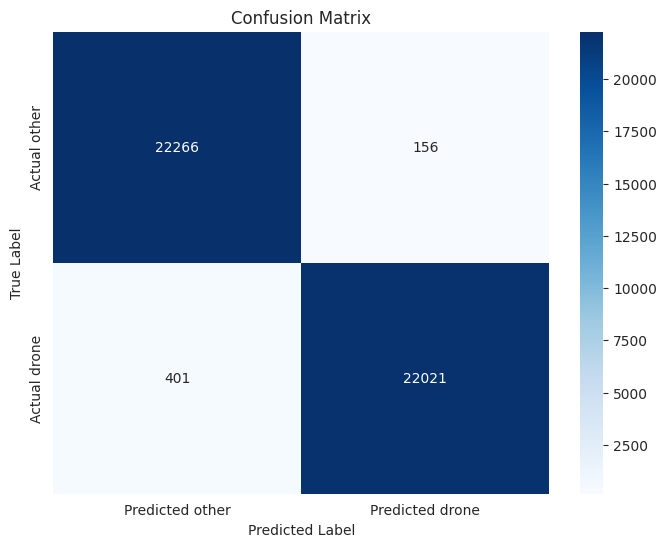


Results DataFrame head:
   true_label  pred_label  confidence
0         0.0         0.0    0.002682
1         0.0         0.0    0.167011
2         0.0         0.0    0.000006
3         0.0         0.0    0.007013
4         1.0         1.0    0.999988


In [8]:
# -----------------------------
# 11. Analyze Test Results
# -----------------------------
# --- Overall Accuracy ---
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

# --- Classification Report ---
# Assuming 0 is 'fake' and 1 is 'real', or 'Class 0' and 'Class 1'
# Adjust target_names if you have the actual class names
try:
    # Try to get names from dataset features if they exist
    target_names = dataset["train"].features["label"].names
    if len(target_names) != 2: # Fallback if it's not binary
        target_names = ["Class 0", "Class 1"]
except:
    target_names = ["Class 0", "Class 1"]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=3))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Predicted {target_names[0]}", f"Predicted {target_names[1]}"],
            yticklabels=[f"Actual {target_names[0]}", f"Actual {target_names[1]}"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Store results in a DataFrame (optional) ---
df_results = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_preds,
    "confidence": all_probs
})

print("\nResults DataFrame head:")
print(df_results.head())

In [9]:
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")
ds_test_online2 = load_dataset("Usernameeeeee/drone_test_2", split="test")

def swap_labels(example):
    example["label"] = 1 - example["label"]   # flips 0 ↔ 1
    return example

ds_test_online = ds_test_online.map(swap_labels)
ds_test_online2 = ds_test_online2.map(swap_labels)

In [10]:
import librosa
def convert_to_mel_spectrogram(data):
    mel = librosa.feature.melspectrogram(
        y=data,
        sr=sampling_rate,
        n_fft=1025,
        hop_length=256,
        n_mels=128,
        fmin=20,
        fmax=8000,
        power=2.0
    )
     # Convert to log scale (dB)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)
    # Convert to torch tensor: [1, n_mels, time]
    mel_db = torch.tensor(mel_db).unsqueeze(0)

    return mel_db


def collate_fn_librosa_test(batch):
    inputs = []
    labels = []

    for item in batch:
        waveforme = item["audio"]["array"]
        wave = convert_to_mel_spectrogram(waveforme)
        wave = wave.repeat(3, 1, 1)
        inputs.append(wave)
        labels.append(item["label"])

    # Pad time dimension so all samples in batch have same T
    # (ResNet requires fixed size)
    inputs = torch.nn.utils.rnn.pad_sequence(
        inputs, batch_first=True
    )  # → [B, 3, 128, T_max]

    labels = torch.tensor(labels, dtype=torch.float32)

    return inputs, labels


test_loader_1 = DataLoader(
    ds_test_online,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn_librosa_test,
)
test_loader_2 = DataLoader(
    ds_test_online2,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn_librosa_test,
)


y_true1, y_pred1, y_true2, y_pred2 = [], [], [], []

with torch.no_grad():
    for x, y in tqdm(test_loader_1, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred1.extend(preds.cpu().numpy())
        y_true1.extend(y.cpu().numpy())

with torch.no_grad():
    for x, y in tqdm(test_loader_2, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred2.extend(preds.cpu().numpy())
        y_true2.extend(y.cpu().numpy())

Testing: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = float("nan")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "confusion_matrix": cm,
    }

metrics1 = compute_metrics(y_true1, y_pred1)
metrics2 = compute_metrics(y_true2, y_pred2)

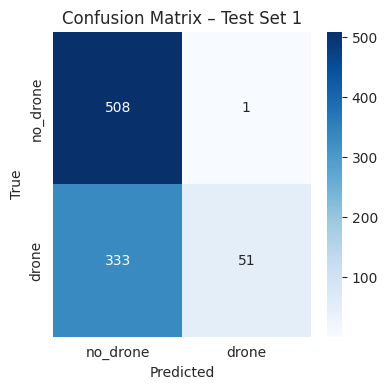

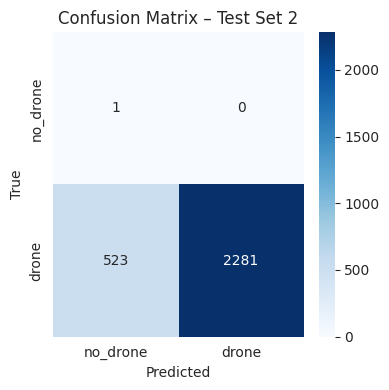

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["no_drone", "drone"]

def plot_confusion(cm, title):
    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(metrics1["confusion_matrix"], "Confusion Matrix – Test Set 1")
plot_confusion(metrics2["confusion_matrix"], "Confusion Matrix – Test Set 2")